## Install graph libraries

In [1]:
pip install neo4j-driver

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install graphdatascience

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pandas numpy pathlib sys

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


Load libraries

In [4]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience

Connect to Neo4j database and test

In [5]:
# Neo4j Connection details
DB_ULR = 'bolt://3.238.155.148:7687'
DB_USER = 'neo4j'
DB_PASS = 'growth-laboratory-party'
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))
gds.version()

'2.5.5'

In [6]:
nodes = gds.run_cypher('''
    MATCH (n)
    RETURN COUNT(n)
''') 
nodes.head()

,COUNT(n)
0,8671


## Load MovieLens data.
Here we use data from [GroupLens.org](https://grouplens.org/datasets/movielens/). Espesially, the "[1M Dataset](https://files.grouplens.org/datasets/movielens/ml-1m.zip)". The zip file is decompressed and the contens are placed in the same folder as the notebook (or in case of colab are uploaded to colab).   

For better results it is suggested that a bigger dataset is used.

In [7]:
movies = pd.read_csv('movies_minimal_test.dat',sep='::',encoding = "ISO-8859-1",names=['MovieID','Title','Genres'])
ratings = pd.read_csv('ratings_minimal_test.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv('users_minimal_test.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','Gender','Age','Occupation','Zip_code'])

C:\Users\user\AppData\Local\Temp\ipykernel_4568\1228820786.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('movies_minimal_test.dat',sep='::',encoding = "ISO-8859-1",names=['MovieID','Title','Genres'])
C:\Users\user\AppData\Local\Temp\ipykernel_4568\1228820786.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('ratings_minimal_test.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','MovieID','Rating','Timestamp'])
C:\Users\user\AppData\Local\Temp\ipykernel_4568\1228820786.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine do

In [8]:
display(movies)
display(users)
display(ratings)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


,UserID,Gender,Age,Occupation,Zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,F,1,11,48088
4,5,F,58,18,70067
5,6,M,30,15,55229
6,7,F,8,11,48754
7,8,F,56,7,70995
8,9,M,25,22,55224
9,10,F,13,11,48000


,UserID,MovieID,Rating,Timestamp
0,1,1,5,978300760
1,1,20,5,978302109
2,8,4,3,978301968
3,2,11,5,978300760
4,2,2,5,978302109
5,5,1,4,978302109
6,3,10,5,978302109
7,4,1,2,978300560
8,7,16,5,978302180
9,5,11,4,978301950


## Insert data to graph DB

In [9]:
# Create user nodes
gds.run_cypher('create constraint if not exists for (n:User) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:User{id: row.UserID})
    set n.Gender = row.Gender
    set n.Age =  row.Age 
    return count(*) as customers_created
''', params = {'data': users.to_dict('records')})
create_customer_res.head()

,customers_created
0,12


In [10]:
# Create movies nodes
gds.run_cypher('create constraint if not exists for (n:Movie) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:Movie{id: row.MovieID})
    set n.Title = row.Title
    set n.Genres =  row.Genres 
    return count(*) as movies_created
''', params = {'data': movies.to_dict('records')})
create_customer_res.head()

,movies_created
0,20


Ratings data frame is quite large dataframe, hence we split it in chunks and then upload one chunk at a time.

In [11]:
i = 1
for chunk in np.array_split(ratings, 200):
    if i % 10 == 0:
        print(i)
    create_rated = gds.run_cypher('''
        UNWIND $data as row
        MATCH (u:User {id: row.UserID}), (m:Movie {id: row.MovieID})
        MERGE (u)-[r:RATED]->(m)
        SET r.Rating = row.Rating
        RETURN count(*) as create_rated
    ''', params={'data': chunk.to_dict('records')})
    i = i + 1
create_rated.head()


10
20
30
40
50
60
70


In [ ]:
pip install apoc

In [ ]:
import apoc

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://3.238.155.148:7687"
username = "neo4j"
password = "growth-laboratory-party"

with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        result = session.run("CALL apoc.meta.schema() YIELD value")
        for record in result:
            print(record["value"])


{'User': {'count': 24, 'labels': [], 'properties': {'id': {'unique': False, 'indexed': True, 'type': 'INTEGER', 'existence': False}, 'Age': {'unique': False, 'indexed': False, 'type': 'INTEGER', 'existence': False}, 'Gender': {'unique': False, 'indexed': False, 'type': 'STRING', 'existence': False}}, 'type': 'node', 'relationships': {'RATED': {'count': 0, 'direction': 'out', 'labels': ['Movie'], 'properties': {'Rating': {'indexed': False, 'type': 'INTEGER', 'existence': False, 'array': False}}}, 'SIMILAR': {'count': 7, 'direction': 'out', 'labels': ['User', 'User'], 'properties': {'Similarity': {'indexed': False, 'type': 'FLOAT', 'existence': False, 'array': False}}}}}, 'RATED': {'count': 18, 'properties': {'Rating': {'indexed': False, 'type': 'INTEGER', 'existence': False, 'array': False}}, 'type': 'relationship'}, 'ON_CONTINENT': {'count': 8668, 'properties': {}, 'type': 'relationship'}, 'IN_REGION': {'count': 6955, 'properties': {}, 'type': 'relationship'}, 'HAS_ROUTE': {'count': 46

* To get schema use
```
  CALL apoc.meta.schema()
```
* To visualize schem use
```
  CALL db.schema.visualization()
```
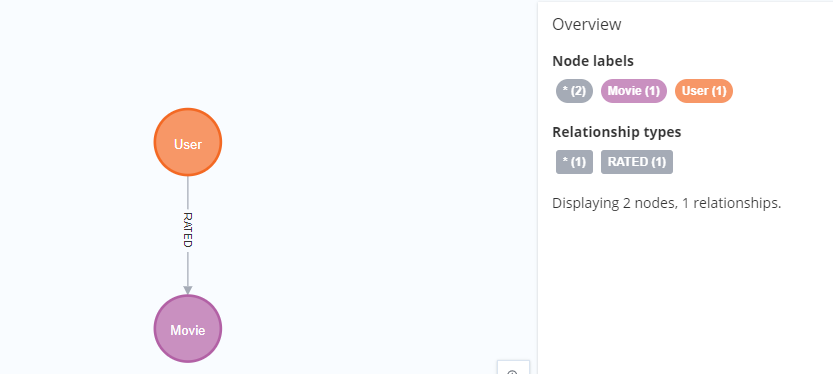


## Recommendations

### Recomendation of similar movie
A simple way to find similar movies for a specific movie is to count how many paths of the form  
$(movie_1)-[]\rightarrow(user)-[]\rightarrow(movie_2)$  
there are,   
where $movie_1$ is the movie we want to find similar movies for.  
We order $movie_2$ based on the number of paths that connect the two movies. The idea is that similar movies would recieve excellent rating by the same user.


In [ ]:
# Check similar movies
similar_movies = gds.run_cypher('''
    MATCH(m1:Movie)-[r1]-(u:User)-[r2]-(m2:Movie)
    WHERE m1.Title CONTAINS 'Toy Story (1995)'
      AND m2.Title<>'Toy Story (1995)'
      AND r1.Rating=5 AND r2.Rating=5
    RETURN m2.Title,m2.Genres,count(DISTINCT(u)) as common_users
    ORDER BY common_users DESC
''')
similar_movies.head()

,m2.Title,m2.Genres,common_users
0,Jumanji (1995),Adventure|Children's|Fantasy,2
1,A League of Their Own (1992),Action|Adventure|Thriller,1
2,Apollo 13 (1995),Action|Adventure|Thriller,1


And a parametric query

In [ ]:
# Check similar movies
similar_movies = gds.run_cypher('''
    MATCH(m1:Movie)-[r1]-(u:User)-[r2]-(m2:Movie)
    WHERE m1.Title CONTAINS $title
        AND m2.Title<>$title
        AND r1.Rating=5 AND r2.Rating=5
    RETURN m2.Title,m2.Genres,count(DISTINCT(u)) as common_users
    ORDER BY common_users DESC
''',params = {'title':'Jumanji (1995)'})
similar_movies.head()

,m2.Title,m2.Genres,common_users
0,Toy Story (1995),Animation|Children's|Comedy,2
1,A League of Their Own (1992),Action|Adventure|Thriller,1
2,Apollo 13 (1995),Action|Adventure|Thriller,1


In [ ]:
similar_movies.head(50)

,m2.Title,m2.Genres,common_users
0,Toy Story (1995),Animation|Children's|Comedy,2
1,A League of Their Own (1992),Action|Adventure|Thriller,1
2,Apollo 13 (1995),Action|Adventure|Thriller,1


### User based recommendation
Next, we create recommendations for a user.   
This is done by first calculationg a similarity measure/score between users. For this we use Jaccard similarity. The whole process is done in Neo4j DB.
- First by creating a projection
- Then by calculating the actual Jaccard similarity

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://3.238.155.148:7687"
username = "neo4j"
password = "growth-laboratory-party"

with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        session.run("CALL gds.graph.drop('ProjectttNeo4jGraph');")

In [ ]:
# Create projection
create_projection = gds.run_cypher('''
   CALL gds.graph.project(
    'ProjectttNeo4jGraph',
    ['User', 'Movie'],
    {
        RATED: {properties:  'Rating'}
            } 
);
''')
create_projection.head()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'RATED': {'aggregation': 'DEFAULT', 'orientat...",ProjectttNeo4jGraph,44,18,13


In [ ]:
from neo4j import GraphDatabase

uri = "bolt://3.238.155.148:7687"
username = "neo4j"
password = "growth-laboratory-party"

with GraphDatabase.driver(uri, auth=(username, password)) as driver:
    with driver.session() as session:
        session.run("CALL gds.graph.drop('ProjectttNeo4jGraph');")  # Drop existing graph

# Create projection
create_projection = gds.run_cypher('''
    CALL gds.graph.project(
        'ProjectttNeo4jGraph',
        ['User', 'Movie'],
        {
            RATED: {properties: 'Rating'}
        } 
    );
''')
create_projection.head()


,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'User': {'label': 'User', 'properties': {}}, ...","{'RATED': {'aggregation': 'DEFAULT', 'orientat...",ProjectttNeo4jGraph,44,18,19


* To delete 'myGraph' use  
    ```
    CALL gds.graph.drop('myGraph')
    ````
* To list graph projections use  
    ```
    CALL gds.graph.list()
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName, nodeCount, relationshipCount
    ORDER BY graphName ASC
    ```

In [ ]:
# Get user similarity
users_similarity = gds.run_cypher('''
CALL gds.nodeSimilarity.stream('ProjectttNeo4jGraph')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS UserID1, gds.util.asNode(node2).id AS UserID2, similarity
ORDER BY similarity DESCENDING, UserID1, UserID2
''')
users_similarity

,UserID1,UserID2,similarity
0,1,9,0.500000
1,2,5,0.500000
2,4,5,0.500000
3,5,2,0.500000
4,5,4,0.500000
5,9,1,0.500000
6,1,2,0.333333
7,2,1,0.333333
8,3,4,0.333333
9,4,3,0.333333


Next, we create a new relationship between users. Similarity score between them is add as an attribute.

In [ ]:
# Create Similar relationship
i=1
for chunk in np.array_split(users_similarity.query('UserID1>UserID2'),10):
  print(i)
  create_similar = gds.run_cypher('''
    unwind $data as row
    match (u1:User{id: row.UserID1}), (u2:User{id: row.UserID2})
    merge (u1)-[r:SIMILAR]->(u2)
    set r.Similarity=row.similarity
    return count(*) as create_rated
    ''', params = {'data': chunk.to_dict('records')})
  i = i+1
create_similar.head()

1
2
3
4
5
6
7
8
9
10


,create_rated
0,1


In [ ]:

# Split data into chunks
chunks = np.array_split(users_similarity.query('UserID1>UserID2'), 10)

# Store results in a list
create_similar_results = []

for i, chunk in enumerate(chunks):
    print(f"Iteration {i + 1}")
    create_similar = gds.run_cypher('''
        UNWIND $data as row
        MATCH (u1:User{id: row.UserID1}), (u2:User{id: row.UserID2})
        MERGE (u1)-[r:SIMILAR]->(u2)
        SET r.Similarity=row.similarity
        RETURN count(*) as create_rated
    ''', params={'data': chunk.to_dict('records')})
    
    # append the result to the list
    create_similar_results.append(create_similar)
create_similar_df = pd.concat([result.head() for result in create_similar_results])

# display the final DataFrame
create_similar_df


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


,create_rated
0,2
0,2
0,2
0,1
0,1
0,1
0,1
0,1
0,1
0,1


In order to recommend movies to $user_1$, we:   
1. find similar users and then movies they have rated
2. for each movie we found in step (1), we calculate average rating weighted by similariy score:  
$ r_{m,avg}=\frac{1}{\sum s_{user_2}}\sum s_{user_2}r_{m}$   
where sum runs over all paths   
$(user_1)-[s_{user_2}]-(user_2)-[r_m]→(movie)\$  

In the implementation below, we add term $log(number\_of\_paths)$ to boost movies that are connected to $user_1$ throught multiple such paths. 

In [ ]:
# Check similar movies
similar_movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r1:SIMILAR]-(u2)-[r2:RATED]-(m:Movie)
    WHERE id(u1)=$id
    AND NOT ( (u1)-[]-(m))
    RETURN m.Title,m.Genres,Sum(r1.Similarity*r2.Rating)/sum(r1.Similarity)+log(count(r2)) as score
    ORDER BY score DESC
''',params = {'id':1})
similar_movies_for_user.head(10)

,m.Title,m.Genres,score
0,GoldenEye (1995),Action|Adventure|Thriller,5.000000
1,Apollo 13 (1995),Action|Adventure|Thriller,4.568147
2,Johnny Mnemonic (1995),Action,4.000000
3,Waiting to Exhale (1995),Comedy|Drama,3.000000


In [ ]:
# Check actual movies
movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r:RATED]-(m:Movie)
  WHERE id(u1)=$id
  RETURN m.Title,m.Genres,r.Rating as rating
  ORDER BY rating DESC
''',params = {'id':2})
movies_for_user.head(10)

,m.Title,m.Genres,rating
0,GoldenEye (1995),Action|Adventure|Thriller,5
1,Johnny Mnemonic (1995),Action,4
2,Toy Story (1995),Animation|Children's|Comedy,4
